# Assessment 2

In [84]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures


In [61]:
#reading in the data for mhd
mhd_ch4 = pd.read_csv('data/mhd_ch4.csv')
mhd_co2= pd.read_csv('data/mhd_co2.csv')
mhd_n2o = pd.read_csv('data/mhd_n2o.csv')

#reading in data for tac
tac_ch4 = pd.read_csv('data/tac_ch4.csv')
tac_co2= pd.read_csv('data/tac_co2.csv')
tac_n2o = pd.read_csv('data/tac_n2o.csv')

#reading in species information
spec_info = pd.read_csv('data/species_info.csv')  
print(spec_info)
#creating dictionaries to make it easier to access data
tac_mhd = {'tac_ch4': tac_ch4, 'tac_co2': tac_co2, 'tac_n2o': tac_n2o, 'mhd_ch4':mhd_ch4, 'mhd_co2':mhd_co2, 'mhd_n2o':mhd_n2o}



  species scale units
0     co2  noaa   ppm
1     ch4   sio   ppb
2     n2o   sio   ppb


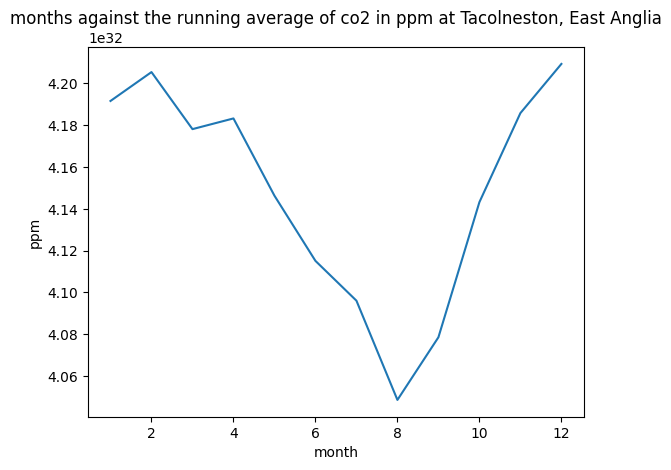

C:\Users\sarah\AppData\Local\Temp\ipykernel_8336\2303339205.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_final['pred_mf'] = model.predict(X)


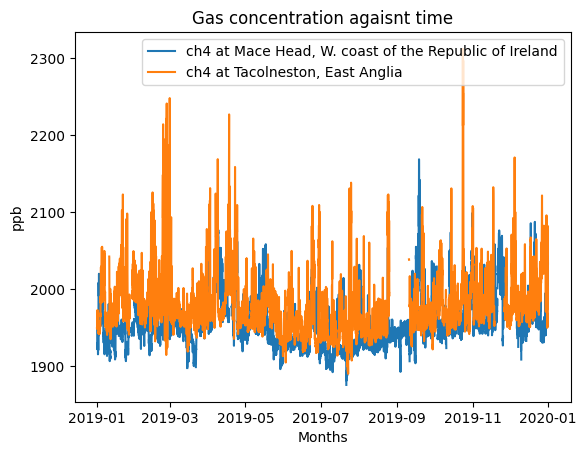

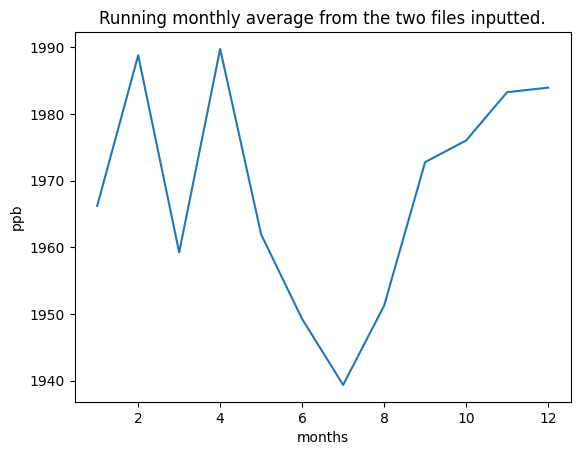

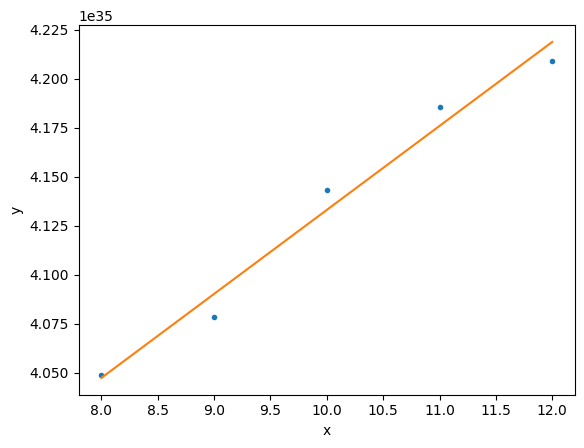

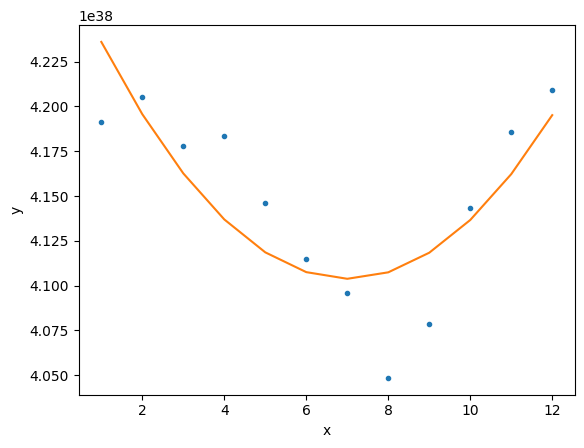

In [88]:
class Data:

   def __init__(self,data: dict, info):
      self.data = data
      self.info = info
      
   def metadata(self,file_meta):
      self.file_meta = file_meta
      self.sitecode = self.file_meta[:3]
      if self.sitecode == 'tac':
         self.sitename = 'Tacolneston, East Anglia'
      if self.sitecode == 'mhd':
         self.sitename = 'Mace Head, W. coast of the Republic of Ireland'
      
      row = self.info.loc[self.info['species'] == self.file_meta[4:]]
      
      self.gas_species = row.iloc[0]['species']
      self.cali_scale = row.iloc[0]['scale']
      self.units = row.iloc[0]['units']

      return self.sitename, self.gas_species, self.cali_scale, self.units

   def user_metadata(self,file_meta_user):
      self.file_meta_user = file_meta_user
      self.sitecode_u = self.file_meta_user[:3]
      if self.sitecode_u == 'tac':
         print('The location of this data set is Tacolneston, East Anglia.\nThe site code is TAC')
         self.sitename_u = 'Tacolneston, East Anglia'
      if self.sitecode_u == 'mhd':
         print('The location of this data set is Mace Head, W. coast of the Republic of Ireland.\nThe site code is MHD')
         self.sitename_u = 'Mace Head, W. coast of the Republic of Ireland'
      
      row_u = self.info.loc[self.info['species'] == self.file_meta_user[4:]]
      
      self.gas_species_u = row_u.iloc[0]['species']
      self.cali_scale_u = row_u.iloc[0]['scale']
      self.units_u = row_u.iloc[0]['units']

      

      print(f'the gas species is {self.gas_species_u} ')
      print(f'the scale used is {self.cali_scale_u} ')
      print(f'the units are {self.units_u} ')
      
   def run_avg(self, file_avg):
      self.file_avg = file_avg
      df_avg = self.data[self.file_avg]
      df_avg['time'] = pd.to_datetime(df_avg['time'])
      if self.time_frame == 'month':
            df_avg[self.time_frame] = df_avg['time'].dt.month
      elif self.time_frame == 'year':
         df_avg[self.time_frame] = df_avg['time'].dt.year
      elif self.time_frame == 'day':
         df_avg[self.time_frame] = df_avg['time'].dt.day
      else:
         print("Invalid time frame")
      grouped_df = df_avg.groupby(self.time_frame)
      avg_vals = grouped_df['mf'].mean()
      x = list(avg_vals.index)
      y  = []
      for i in x:
         y.append(avg_vals[i])
      
      return x, y
   def con_to_ppb(self,file_con):
      self.file_con = file_con
      sitename, species, caliscale, units = self.metadata(self.file_con)
      df = self.data[self.file_con]
      if units == 'ppm':
         df['mf'] = df['mf']*1000
      return df     
   def run_avg_2vals(self, file1_2avs, file2_2avs):
      
      self.file1_2avs = file1_2avs
      self.file2_2avs = file2_2avs


      self.df_file1_2avs = self.con_to_ppb(self.file1_2avs) 
      self.df_file2_2avs = self.con_to_ppb(self.file2_2avs)
      
      self.df_file1 = self.data[self.file1_2avs]
      self.df_file2 = self.data[self.file2_2avs]
      
   
      self.df_file1['time'] = pd.to_datetime(self.df_file1['time'])
      self.df_file2['time'] = pd.to_datetime(self.df_file2['time'])

      df_merge = pd.merge(self.df_file1, self.df_file2, on="time", how="inner")
      df_merge['sum'] = df_merge['mf_x']+df_merge['mf_y']
      df_merge['avg'] = df_merge['sum']/2
      df_merge['time'] = pd.to_datetime(df_merge['time'])
   
      df_merge['month'] = df_merge['time'].dt.month
      grouped_merge = df_merge.groupby('month')
      df_merge_mean = grouped_merge['avg'].mean().reset_index()

      x_1 = self.df_file1['time']
      y_1 = self.df_file1['mf']

      x_2 = self.df_file2['time']
      y_2 = self.df_file2['mf']

      x_3 = df_merge_mean['month']
      y_3 = df_merge_mean['avg']

      return x_1, y_1, x_2, y_2, x_3, y_3

   def plot_run_avgs(self, file, time_frame):
      self.file = file
      self.time_frame = time_frame
      
      site, species, cali, units = self.metadata(file)
      x , y = self.run_avg(file)
      fig, ax = plt.subplots()
      
      ax.plot(x, y)
      ax.set_xlabel(self.time_frame)
      ax.set_ylabel(self.units)
      ax.set_title(f'{self.time_frame}s against the running average of {species} in {units} at {site}')
      plt.show()
   
   def m_vs_t(self, file1, file2, timeframe2):
      self.timeframe2 = timeframe2
      self.file1 = file1
      self.file2 = file2
      
      x_1 , y_1, x_2, y_2, x_3, y_3 = self.run_avg_2vals(file1,file2)
      file1_site, file1_gspec, file1_cali, file1_units = self.metadata(file1)
      file2_site, file2_gspec, file2_cali, file2_units = self.metadata(file2)
      fig ,ax = plt.subplots()
      ax.set_xlabel('Months')
      ax.set_ylabel('ppb')
      ax.set_title('Gas concentration agaisnt time')
      ax.plot(x_1, y_1, label = f'{file1_gspec} at {file1_site}')
      ax.plot(x_2, y_2, label = f'{file2_gspec} at {file2_site}')
      ax.legend()
      fig ,ax = plt.subplots()
      ax.set_ylabel('ppb')
      ax.set_xlabel('months')
      ax.set_title('Running monthly average from the two files inputted.')
      ax.plot(x_3, y_3)
   def linear_fit(self,ml_file, start_month, end_month):
      self.start_month = start_month
      self.end_month = end_month
      self.ml_file = ml_file

      model = linear_model.LinearRegression(fit_intercept = True)
      ml_df = self.data[self.ml_file]
      ml_df = self.con_to_ppb(ml_file)
      ml_avg = self.run_avg(ml_file)

      month = ml_avg[0]
      
      mf = ml_avg[1]
      
      ml = pd.DataFrame({'month':month, 'mf':mf})
      ml_final = ml.loc[(ml['month']>=self.start_month) & (ml['month']<=self.end_month)]
      X = ml_final[['month']]
      Y= ml_final['mf']
      
      model.fit(X,Y)
      
      ml_final['pred_mf'] = model.predict(X)

      fig, ax  = plt.subplots()

      # Create a scatter plot of the known x-y values
      ax.plot(ml_final["month"],ml_final["mf"],'.')

      # Draw a line to represent the predicted y-values
      ax.plot(ml_final["month"],ml_final["pred_mf"])

      # Axis labels to be tidy
      ax.set_xlabel("x")
      ax.set_ylabel("y")
   def poly_fit(self, ply_file, start_month, end_month, n):
      
      self.start_month_p = start_month
      self.end_month_p = end_month
      self.ply_file = ply_file

      
      ply_df = self.data[self.ply_file]
      ply_df = self.con_to_ppb(ply_file)
      ply_avg = self.run_avg(ply_file)

      month = ply_avg[0]
      mf = ply_avg[1]

      ply = pd.DataFrame({'month':month, 'mf':mf})
      ply_final = ply.loc[(ply['month']>=self.start_month_p) & (ply['month']<=self.end_month_p)]
      X = ply_final[['month']]
      Y= ply_final['mf']

      # Create a polynomial feature transformer
      poly = PolynomialFeatures(degree=2)

      # Transform the dataset
      X_poly = poly.fit_transform(X)

      # Create a linear regression model
      lin_reg = linear_model.LinearRegression()

      # Fit the model to the transformed dataset
      lin_reg.fit(X_poly, Y)

      

      # Generate the y values for the model using the plot x values and the model's predict method
      y_plot = lin_reg.predict(poly.transform(X))
      fig, ax = plt.subplots()
      # Create a scatter plot of the known x-y values
      ax.plot(ply_final["month"],ply_final["mf"],'.')

      # Draw a line to represent the predicted y-values
      ax.plot(ply_final["month"],y_plot)

      # Axis labels to be tidy
      ax.set_xlabel("x")
      ax.set_ylabel("y")



   
data_tac_mhd = Data(tac_mhd,spec_info)

data_tac_mhd.plot_run_avgs('tac_co2', 'month')

data_tac_mhd.m_vs_t('mhd_ch4', 'tac_ch4', 'month')

data_tac_mhd.linear_fit('tac_co2', 8, 12)

data_tac_mhd.poly_fit('tac_co2',1,12,2)

In [63]:
# class Data:
#  def __init__(self,data: dict):
#     self.tac_ch4 = data['tac_ch4']
    
#  def tac_metadata(self,species):
#     print(self.species)
# data_tac = Data(tac_mhd)
# data.tac_metadata(tac_mhd['tac_ch4'])